Importy i start klienta

In [78]:
import binance
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
client = binance.Client()

In [79]:
def get_data(asset):
    candles = client.get_klines(symbol=asset, interval='1m')
    df = pd.DataFrame(candles, columns=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 
									'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 
									'Taker buy quote asset volume', 'Ignore']).astype("float") # bo domyślnie to są stringi xd
    # Wzór na RSI kradziony z https://www.learnpythonwithrune.org/pandas-calculate-the-relative-strength-index-rsi-on-a-stock/
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    ema_up = up.ewm(com=13, adjust=False).mean()
    ema_down = down.ewm(com=13, adjust=False).mean()
    rs = ema_up/ema_down
    df['RSI'] = 100 - (100/(1 + rs))
    # Wyrzucamy pierwsze 14 dni żeby mieć wiarygodne wartości RSI
    df = df.iloc[14:]
    return df

def plot_data(symbol, df):
    # kradzione z https://python.plainenglish.io/a-simple-guide-to-plotly-for-plotting-financial-chart-54986c996682
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Candlestick(x=df['Close time'],
                    open=df['Open'],
                    high=df['High'],
                    low=df['Low'],
                    close=df['Close'], name=symbol))
    fig.add_trace(go.Scatter(x=df['Close time'], 
                            y=df['RSI'], 
                            opacity=0.7, 
                            line=dict(color='blue', width=2), 
                            name='RSI'), secondary_y=True)
    fig.show()

In [80]:
plot_data("ATOMUSDT", get_data("ATOMUSDT"))

Spread na podstawie order booków

Ask = 26.61
Bid = 26.57
Spread = 0.04


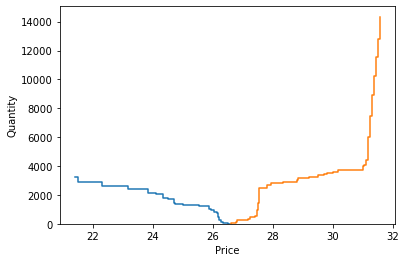

In [82]:
# inspired by https://tiao.io/post/exploring-the-binance-cryptocurrency-exchange-api-orderbook/

data = client.get_order_book(symbol = "WNXMUSDT")
bids = pd.DataFrame(data["bids"], columns= {"price", "quantity"}).astype('float')
asks = pd.DataFrame(data["asks"], columns= {"price", "quantity"}).astype('float')

print("Ask = " + str(min(asks["price"])))
print("Bid = " + str(max(bids["price"])))
print("Spread = " + str(round(min(asks["price"]) - max(bids["price"]), 4)))
fig, ax = plt.subplots()

sns.ecdfplot(x="price", weights="quantity", stat="count", complementary=True, data=bids, ax=ax)
sns.ecdfplot(x="price", weights="quantity", stat="count", data=asks, ax=ax)

ax.set_xlabel("Price")
ax.set_ylabel("Quantity")

plt.show()